**Assignment 2: Word Embeddings using keras**

---



Import Packages


In [ ]:
!pip install labml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 8.6 MB/s 
     |████████████████████████████████| 182 kB 44.6 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 


In [ ]:
import numpy as np  
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from keras.utils import np_utils, pad_sequences
from keras.preprocessing.text import Tokenizer
from labml import logger
from labml.logger import Text, Color
import nltk
from nltk.tokenize import word_tokenize
import re
from collections import Counter, defaultdict
import string
from pickle import dump, load
from unicodedata import normalize
import pandas as pd 
import random
from scipy import linalg
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
from scipy import linalg

Mount drive

In [ ]:
#Load Data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Prepare dataset functions

In [ ]:
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
def tokenize(sentance):
  return sentance.strip().split(' ')
def link_words_and_indexes(data):
    words = sorted(list(set(data)))
    n = len(words)
    idx = 0
    word2Ind = {}
    Ind2word = {}
    for k in words:
        word2Ind[k] = idx
        Ind2word[idx] = k
        idx += 1
    return word2Ind, Ind2word
def get_idx(words, word2Ind):
    idx = []
    for word in words:
        idx = idx + [word2Ind[word]]
    return idx
def pack_idx_with_word_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed
def get_vectors(data, word2Ind, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2Ind[center_word]] = 1

        context_words = data[(i - C):i] + data[(i+1):(i+C+1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_word_frequency(context_words, word2Ind):
            x[idx] = freq/num_ctx_words
        yield x, y
        i += 1
        if i >= len(data):
            logger.log('i is being set to 0', Text.warning)
            i = 0
def generate_tokens_data(french_vocab, english_vocab):
  english_data, french_data = [],[]
  for french_sentence, english_sentence in zip(french_vocab, english_vocab):
    french_tokens = tokenize(french_sentence)
    english_tokens = tokenize(english_sentence)
    french_data.extend(french_tokens)
    french_data.append('.')
    english_data.extend(english_tokens)
    english_data.append('.')
  return english_data, french_data
def generate_tokens(sentence):
  tokens=[]
  tokens = tokenize(sentence)
  return tokens

Prepare CBOW dataset : context and target indexes

In [ ]:
def generate_context_word_pairs(corpus, window_size, vocab_size,word2Ind_en):
    X = []
    Y = []
    h=0
    context_length = window_size*2
    for index_sentence,words in enumerate(corpus):
      tokens_of_sentense=generate_tokens(words)
      sentence_length=len(tokens_of_sentense)
      for index, word in enumerate(tokens_of_sentense):
        context=[]
        start = index - window_size
        end = index + window_size + 1
        if (end >= sentence_length):
            end=sentence_length-1
        if start <0:
          start=0
        i=start
        context = [tokens_of_sentense[i] for i in range(start, end)if 0 <= i < sentence_length and i != index]
        context_vector=[word2Ind_en[word_context] for i,word_context in enumerate(context)]
        target_vector=word2Ind_en[word]
        x = pad_sequences([context_vector], maxlen=context_length,padding='post')
        new_x=np.append(x,target_vector)
        yield new_x
def get_context_target(english_vocab, word2Ind_en, N, V_en, num_epochs,mode="EN"):
  df = pd.DataFrame(columns=['x1', 'x2', 'x3', 'x4','target'])
  window_size =2
  for x in generate_context_word_pairs(corpus=english_vocab, window_size=window_size, vocab_size=V_en,word2Ind_en=word2Ind_en):
    df.loc[len(df)]=x
  if mode=="EN":
    df.to_csv('/content/gdrive/MyDrive/Projet/context_targetEN.csv', index=False)
  else:
    df.to_csv('/content/gdrive/MyDrive/Projet/context_targetFR.csv', index=False)
  return df

In [ ]:
def train_model(df,english_vocab, word2Ind_en, N, V_en, num_epochs,mode="EN"):
  x_train= df.iloc[:,[0,1,2,3]]
  x_train=np.asarray(x_train).astype("float32")
  y_train=df.iloc[:,[4]]
  y_train = list(y_train.to_numpy().reshape(1,-1))
  embeded_vector_size=N
  max_length=4
  y_train = tf.keras.utils.to_categorical(y_train[0], num_classes=V_en)
  model=Sequential()
  model.add(Embedding(V_en,  # Vocabulary size
                      embeded_vector_size, #Word embeddings size
                      input_length=max_length, 
                      name="embedding"))
  model.add(Flatten())
  model.add(Dense(V_en,activation='softmax'))
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  model.summary()
  model.fit(x_train,y_train,epochs=num_epochs)
  loss,accuracy= model.evaluate(x_train,y_train)
  weights=model.get_layer('embedding').get_weights()[0]
  embeddings= {(w,idx):weights[idx] for w,idx in word2Ind_en.items() }
  #words_embeddings = {w:weights[idx] for w, idx in word2Ind_en.items()}
  return embeddings

In [ ]:
def prepare_words_for_inference(filename):
  english_words, french_words = [], []
  with open(words_filetxt_pth, 'r') as f:
    lines = f.readlines()
  for line in lines:
    en_word, fr_word = line[:-1].split(' ')
    english_words.append(en_word)
    french_words.append(fr_word)
  return english_words, french_words
def prepare_indexes(english_data, french_data, english_words, french_words, word2Ind_en, word2Ind_fr, mode='EN'):
  existed_words = []
  translated_words = []
  max_words = 1500
  if mode == 'EN':
    words = english_words[:max_words]
  else:
    words = french_words[:max_words]
  for idx,word in enumerate(words):
    if mode == 'EN':
      if word in english_data and french_words[idx] in french_data:
        existed_words.append(word) 
        translated_words.append(french_words[idx])
    else:
      if word in french_data and english_words[idx] in english_data:
        existed_words.append(word) 
        translated_words.append(english_words[idx])
  if mode == "EN":
    existed_idx = [word2Ind_en[word] for word in existed_words]
    translated_idx = [word2Ind_fr[word] for word in translated_words]
  else:
    existed_idx = [word2Ind_fr[word] for word in existed_words]
    translated_idx = [word2Ind_en[word] for word in translated_words]
  return existed_words, translated_words, existed_idx, translated_idx
def extract_embeddings(weights_en, weights_fr, indexes_en, indexes_fr):
  return weights_en[indexes_en, :], weights_fr[indexes_fr, :]   
def save_embeddings_to_df(weights_en, weights_fr, indexes_en, indexes_fr, words_en, words_fr, embeddings_vf_pth = '/content/gdrive/MyDrive/Projet/embeddings_vf.csv'):
  en_embeddings, fr_embeddings = extract_embeddings(weights_en, weights_fr, indexes_en, indexes_fr)
  df = pd.DataFrame(columns=['EN-Word', 'EN-Embedding', 'FR-Word', 'FR-Embedding'])
  df['EN-Word'] = words_en
  df['EN-Embedding'] = [en_embeddings[idx].tolist() for idx in range(len(en_embeddings))]
  df['FR-Embedding'] = [fr_embeddings[idx].tolist() for idx in range(len(fr_embeddings))]
  df['FR-Word'] = words_fr
  df.to_csv(embeddings_vf_pth, index = False, header=True)
  return words_en,en_embeddings,words_fr, fr_embeddings
def get_weights(df):
  array = []
  for idx, row in df.iterrows():
    array.append(df.loc[idx, :].values.tolist())
  return np.array(array)

Visualisation function

In [ ]:
#Réduction de dementions
def compute_pca(data, n_components=2):
    m, n = data.shape
    data -= data.mean(axis=0)
    R = np.cov(data, rowvar=False)
    evals, evecs = linalg.eigh(R)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:, idx]
    evals = evals[idx]
    evecs = evecs[:, :n_components]
    return np.dot(evecs.T, data.T).T

In [ ]:
english_vocab_pth = '/content/gdrive/MyDrive/Projet/english_vocab.pkl'
english_vocab = load_clean_sentences(english_vocab_pth)
french_vocab_pth = '/content/gdrive/MyDrive/Projet/french_vocab.pkl'
french_vocab = load_clean_sentences(french_vocab_pth)

In [ ]:
english_vocab=english_vocab[:200]
french_vocab=french_vocab[:200]

In [ ]:
len(english_vocab)

200

In [ ]:
#Tokenazation de vocabulaires
english_data, french_data = generate_tokens_data(french_vocab, english_vocab)

In [ ]:
word2Ind_en, Ind2word_en = link_words_and_indexes(english_data)
word2Ind_fr, Ind2word_fr = link_words_and_indexes(french_data)
V_en=len(word2Ind_en)
V_fr=len(word2Ind_fr)
num_epochs=50
N=100

In [ ]:
V_en,V_fr

(1209, 1431)

In [ ]:
#Génération de contexte et target
df_context_target_fr = pd.DataFrame(columns=['x1', 'x2', 'x3', 'x4','target'])
window_size =2
for x in generate_context_word_pairs(corpus=french_vocab, window_size=window_size, vocab_size=V_fr,word2Ind_en=word2Ind_fr):
   df_context_target_fr.loc[len(df_context_target_fr)]=x

In [ ]:
df_context_target_fr.shape

(5219, 5)

In [ ]:
df_context_target_en = pd.DataFrame(columns=['x1', 'x2', 'x3', 'x4','target'])
window_size =2
for x in generate_context_word_pairs(corpus=english_vocab, window_size=window_size, vocab_size=V_en,word2Ind_en=word2Ind_en):
   df_context_target_en.loc[len(df_context_target_en)]=x

In [ ]:
num_epochs=40
words_emb_fr=train_model(df_context_target_fr,french_vocab, word2Ind_fr, N, V_fr, num_epochs,mode="EN")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            143100    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 1431)              573831    
                                                                 
Total params: 716,931
Trainable params: 716,931
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
164/164 [==============================] - 3s 13ms/step - loss: 7.0748 - accuracy: 0.0728
Epoch 2/40
164/164 [==============================] - 2s 14ms/step - loss: 5.9812 - accuracy: 0.0902
Epoch 3/40
164/164 [==============================] - 2s 14ms/step - loss: 5.1827 - accuracy: 0.1416
Epoch 4/40


In [ ]:
df_words_emb_fr=pd.DataFrame(words_emb_fr).T
df_words_emb_fr.to_csv("/content/gdrive/MyDrive/Projet/embeddings_Words_fr")

In [ ]:
words_emb_en=train_model(df_context_target_en,english_vocab, word2Ind_en, N, V_en, num_epochs,mode="EN")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            120900    
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 1209)              484809    
                                                                 
Total params: 605,709
Trainable params: 605,709
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
158/158 [==============================] - 2s 12ms/step - loss: 6.8880 - accuracy: 0.0852
Epoch 2/40
158/158 [==============================] - 2s 12ms/step - loss: 5.7804 - accuracy: 0.1077
Epoch 3/40
158/158 [==============================] - 2s 12ms/step - loss: 5.0274 - accuracy: 0.1546
Epoch 4/4

In [ ]:
df_words_emb_en=pd.DataFrame(words_emb_en).T
df_words_emb_en.to_csv("/content/gdrive/MyDrive/Projet/embeddings_Words_en")

Extract Embeddings

In [ ]:
emb_en=get_weights(df_words_emb_en)
emb_fr=get_weights(df_words_emb_fr)

In [ ]:
def compute_transformation_matrix(fr_emb, en_emb):
  U, S, Vh = np.linalg.svd(np.dot(fr_emb.T, en_emb))  
  return np.dot(U, Vh)

In [ ]:
words_filetxt_pth='/content/gdrive/MyDrive/Projet/en-fr.txt'
english_words, french_words = prepare_words_for_inference(words_filetxt_pth)
words_en, words_fr, indexes_en, indexes_fr = prepare_indexes(english_data, french_data, english_words, french_words, word2Ind_en, word2Ind_fr)
words_en,en_embeddings,words_fr, fr_embeddings = save_embeddings_to_df(emb_en,emb_fr, indexes_en, indexes_fr, words_en, words_fr)


In [ ]:
transformation_matrix = compute_transformation_matrix(fr_embeddings, en_embeddings)

In [ ]:
transformation_matrix.shape

(100, 100)

In [ ]:
def compute_transformation_matrix(fr_emb, en_emb):
  U, S, Vh = np.linalg.svd(np.dot(fr_emb.T, en_emb))  
  return np.dot(U, Vh)

In [ ]:
fr_embeddings.shape, en_embeddings.shape

((279, 100), (279, 100))

In [ ]:
transformation_matrix = compute_transformation_matrix(fr_embeddings, en_embeddings)

In [ ]:
#fr_emb_translate=np.dot(en_embeddings,transformation_matrix)
en_emb_translate=np.dot(fr_embeddings,transformation_matrix)

In [ ]:
fr_emb_translate

array([[ 0.62042003, -0.11649614, -0.40345558, ..., -0.74036375,
        -0.4720959 , -0.01785317],
       [ 0.62042003, -0.11649614, -0.40345558, ..., -0.74036375,
        -0.4720959 , -0.01785317],
       [ 0.62042003, -0.11649614, -0.40345558, ..., -0.74036375,
        -0.4720959 , -0.01785317],
       ...,
       [-0.24027634, -0.30906564,  0.02937302, ...,  0.39709767,
         0.22742051,  0.44491087],
       [-0.50113873,  0.03162606,  0.14916162, ...,  0.44656765,
         0.03850552,  0.22400558],
       [ 0.27270963,  0.05811806,  0.06916616, ..., -0.44069275,
        -0.50932328,  0.05155256]])

In [ ]:
import numpy as np
from numpy.linalg import norm
def cosine_similarity(u, v):
  return abs(np.dot(u, v) /  (norm (u)* norm(v)))

In [ ]:
sample_idx=1
from scipy import spatial
logger.log(f'Cosine similarity betweens original embeddings and mapped embeddings = {cosine_similarity(en_embeddings[sample_idx], np.dot(transformation_matrix, fr_embeddings[sample_idx+30]))}', Text.value)

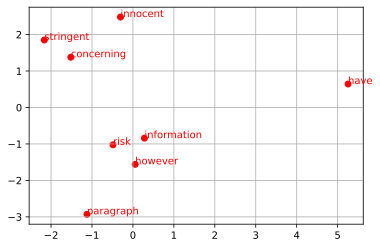

In [ ]:
result_pca_en = compute_pca(en_embeddings, 3)
result_pca_fr = compute_pca(fr_embeddings, 3)
pyplot.grid()
pyplot.scatter(result_pca_en[:50, 0], result_pca_en[:50, 1], color="red")
for i, word in enumerate(words_en[:50]):
    pyplot.annotate(word, xy=(result_pca_en[i, 0], result_pca_en[i, 1]), color="red")
pyplot.show()

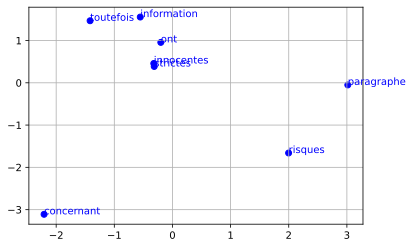

In [ ]:
result_pca_en = compute_pca(en_embeddings, 3)
result_pca_fr = compute_pca(fr_embeddings, 3)
pyplot.grid()
pyplot.scatter(result_pca_fr[:50, 0], result_pca_fr[:50, 1], color="blue")
for i, word in enumerate(words_fr[:50]):
    pyplot.annotate(word, xy=(result_pca_fr[i, 0], result_pca_fr[i, 1]), color="blue")
pyplot.show()

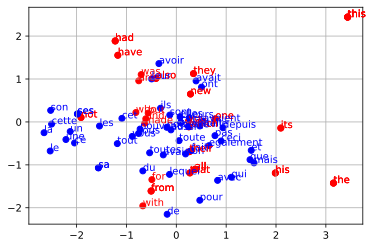

In [ ]:
result_pca_en = compute_pca(en_emb_translate, 3)
result_pca_fr = compute_pca(fr_embeddings, 3)
pyplot.grid()
pyplot.scatter(result_pca_en[:50, 0], result_pca_en[:50, 1], color="red")
pyplot.scatter(result_pca_fr[:50, 0], result_pca_en[:50, 1], color="blue")
for i, (word_en,word_fr) in enumerate(zip(words_en[:50],words_fr[:50])):
    pyplot.annotate(word_en, xy=(result_pca_en[i, 0], result_pca_en[i, 1]), color="red")
    pyplot.annotate(word_fr, xy=(result_pca_fr[i, 0], result_pca_fr[i, 1]), color="blue")
pyplot.show()


In [ ]:
def translate(word, en_words, fr_words, en_embs, fr_embs, top, mode='EN'):
  similarities = {}
  if mode == 'EN':
    word_idx = fr_words.index(word)
    print(f'target word : {word}\n index : {word_idx}')
    #print('---------------------')
    for idx,w in enumerate(en_words):
      similarities[w] = cosine_similarity(en_embs[idx], np.dot(transformation_matrix, fr_embs[word_idx]))
    top_dict = list({k: v for k, v in sorted(similarities.items(), key=lambda item: item[1])}.items())[-top:]
    #for k,v in top_dict:
      #print(f'mapped word : {k}\n index : {en_words.index(k)} \n score : {v}')
      #print(top_dict)
      #print('###################')
    return word_idx,top_dict

In [ ]:
def compute_performance(en_words, fr_words, en_embs, fr_embs, top):
  perf = 0.
  for word in fr_words:
    gt_word_idx, top_similarities = translate(word, en_words, fr_words, en_embs, fr_embs, top=5)
    if gt_word_idx in [en_words.index(k[0]) for k in top_similarities]:
      perf += 1
  return 100 * perf/len(fr_words)

In [ ]:
compute_performance(words_en, words_fr,en_embeddings,fr_embeddings,5)

target word : le
 index : 0
target word : les
 index : 1
target word : la
 index : 2
target word : et
 index : 3
target word : etait
 index : 4
target word : pour
 index : 5
target word : que
 index : 6
target word : cela
 index : 7
target word : avec
 index : 8
target word : du
 index : 9
target word : de
 index : 10
target word : depuis
 index : 11
target word : ceci
 index : 12
target word : cet
 index : 13
target word : cette
 index : 14
target word : cela
 index : 7
target word : ce
 index : 16
target word : sa
 index : 17
target word : ses
 index : 18
target word : son
 index : 19
target word : non
 index : 20
target word : pas
 index : 21
target word : sont
 index : 22
target word : laquelle
 index : 23
target word : lequel
 index : 24
target word : aussi
 index : 25
target word : egalement
 index : 26
target word : mais
 index : 27
target word : avoir
 index : 28
target word : ont
 index : 29
target word : un
 index : 30
target word : une
 index : 31
target word : nouveau
 inde

1.075268817204301